In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import planarity
from qplanarity import load_planar_graphs, generate_graphs, observable, get_trained_model, predict, analyse_pred
from tqdm.notebook import tqdm
from operator import itemgetter
from utils import Memoizer
import pandas as pd

## Planarity module

In [3]:
# Example of the complete graph of 5 nodes, K5
# K5 is not planar
edgelist = [('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'),
            ('b', 'c'),('b', 'd'),('b', 'e'),
            ('c', 'd'), ('c', 'e'),
            ('d', 'e')]

print(planarity.is_planar(edgelist))

# remove an edge to make the graph planar
edgelist.remove(('a','b'))
print(planarity.is_planar(edgelist))

# make an ascii text drawing
print(planarity.ascii(edgelist))

False
True
----1----
| | |   |
| | -2--|
| |  ||||
| -5--|||
|  |  |||
---4---||
 |     ||
 ---3----
         



## Planar graphs

In [4]:
%%time
n = 7 # 9 takes 2s already
graphs = load_planar_graphs(n)
print(len(graphs))
sorted(graphs[0].edges())

646
CPU times: user 15.8 ms, sys: 1.94 ms, total: 17.7 ms
Wall time: 19.3 ms


[(0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6)]

In [5]:
%%time
planars = 0
for graph in tqdm(graphs):
    planars += planarity.is_planar(graph)
assert planars == len(graphs)

  0%|          | 0/646 [00:00<?, ?it/s]

CPU times: user 31.3 ms, sys: 22.6 ms, total: 53.9 ms
Wall time: 79.5 ms


## Tests for development of key getter function for Memoizer

In [6]:
edges = list(map(sorted, graphs[1].edges()))
k1, k2 = tuple(map(tuple, sorted(edges, key=itemgetter(0,1)))), tuple(graphs[1].edges())
d = {}
d[k1] = 'test'  # can be used as key
k1, k2

(((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)),
 ((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)))

## Graph generator

In [7]:
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from utils import return_list_of_states, return_energy_distribution, return_js_matrix, return_js_dist_matrix, entropy, merge_energies
from qutip import mcsolve, sesolve, sigmaz, sigmap, qeye, tensor, Options, expect, sigmam
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
from time import time

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize

In [8]:
np.random.seed(21)
graphs, targets = generate_graphs(range(3, 11), 2 * [50] + 3 * [100] + 3 * [200], generator='binomial', verbose=True)
graphs[:5], targets[:5]

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average


([<networkx.classes.graph.Graph at 0x10e0d4ee0>,
 [True, True, True, True, True])

In [9]:
# graphs, targets = generate_graphs(7, 18)
# graphs[:5], targets[:5]

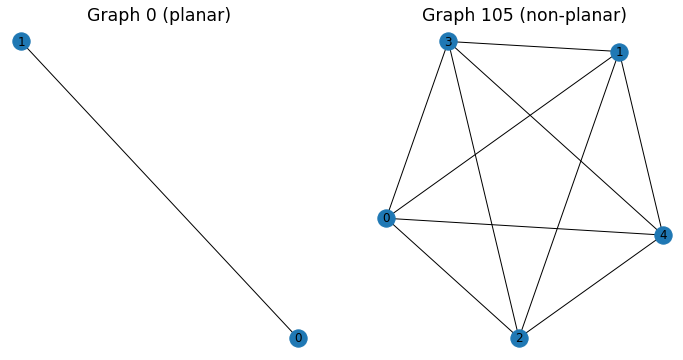

In [10]:
plt.figure(figsize=[12,6])
plt.subplot(121)
i_planar = targets.index(1)
nx.draw(graphs[i_planar], with_labels=True)
plt.title(f"Graph {i_planar} (planar)", fontsize='xx-large')
plt.subplot(122)
i_non_planar = targets.index(0)
nx.draw(graphs[i_non_planar], with_labels=True)
plt.title(f"Graph {i_non_planar} (non-planar)", fontsize='xx-large')
plt.show()

In [11]:
graphs[1].edges

EdgeView([(0, 1)])

## Generate the hamiltonian evolutions

We describe here how to perform a graph classification for specific values of times and pulses for a 2 layers ising evolution.

Generate the final states of all graphs 

In [12]:
times = [2.1, 1.6]
pulses = [0.2, 0.1]

states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot some final states after evolution

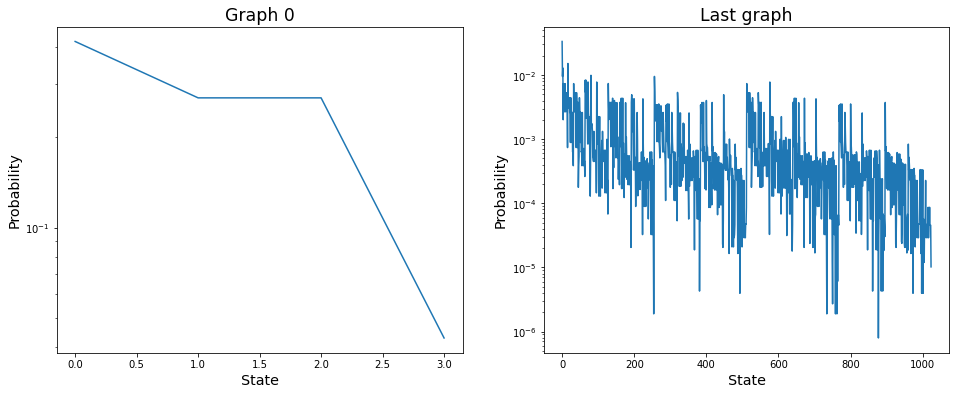

In [13]:
plt.figure(figsize=[16,6])
plt.subplot(121)
prob = np.abs(states[0].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
prob = np.abs(states[-1].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Last graph", fontsize='xx-large')
plt.show()

Compute the probability distribution of the Ising observable from each state.

In [14]:
observables_memoizer = Memoizer(observable)

Compute the probability distribution and the distance matrix

In [15]:
energies_masses, energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, verbose=True, return_energies=True)
matrix = return_js_matrix(energies_masses)

  0%|          | 0/1000 [00:00<?, ?it/s]

Fit the model

In [16]:
K = np.exp(-matrix)
C_list = np.logspace(-3, 3, 7)

param_grid = {'C': C_list}
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='weighted')
            }

skf = RepeatedStratifiedKFold(10, 10, random_state=47)

estimator = svm.SVC(kernel='precomputed', random_state=76)

grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                cv=skf, refit='accuracy', n_jobs=-1)
result = grid_search.fit(K, targets).cv_results_

i_best = np.argmax(result['mean_test_accuracy'])
print('Accuracy: ', result['mean_test_accuracy'][i_best], '±', result['std_test_accuracy'][i_best])


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy:  0.9975 ± 0.005722761571129804


5

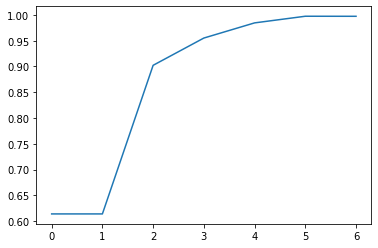

In [17]:
plt.plot(result['mean_test_accuracy'])
i_best

## Investigate generalisation capabilities

In [18]:
def tester(model, graphs, targets, energies_masses, energies):  
    times = [2.1, 1.6]
    pulses = [0.2, 0.1]

    states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=1)
    _energies_masses, _energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, return_energies=True, verbose=True)
    print(energies_masses.shape, _energies_masses.shape)
    energies_masses, _energies_masses = merge_energies(energies_masses, energies, _energies_masses, _energies)
    print(energies_masses.shape, _energies_masses.shape)
    print(energies.shape, _energies.shape)
    print(energies)
    # Should build correct test kernel | Ref.: https://stats.stackexchange.com/a/96881
    matrix = return_js_dist_matrix(_energies_masses, energies_masses, verbose=True)
    K = np.exp(-matrix)

    return model.predict(K), targets, model.score(K, targets)

In [19]:
merge_energies(np.array([[1, 2], [1, 2]]), [1, 2], np.array([[-1], [-1]]), [-1])

(array([[0., 1., 2.],
        [0., 1., 2.]]),
 array([[-1.,  0.,  0.],
        [-1.,  0.,  0.]]))

In [20]:
tester(grid_search, graphs, targets, energies_masses, energies)[2]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 54)
(1000, 54) (1000, 54)
(54,) (54,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

0.999

In [21]:
test_graphs, test_targets = generate_graphs([18], [10], generator='binomial')
test_graphs[:5], test_targets[:5]

([<networkx.classes.graph.Graph at 0x166b3b490>,
 [False, False, False, False, True])

In [22]:
tester(grid_search, test_graphs, test_targets, energies_masses, energies)[2]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(1000, 54) (10, 106)
(1000, 106) (10, 106)
(54,) (106,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

1.0

In [23]:
scores = []
ns = range(3, 16)
for n in ns:
    test_graphs, test_targets = generate_graphs([n], [1000], generator='binomial')
    y_pred, y_true, score = tester(grid_search, test_graphs, test_targets, energies_masses, energies)
    print(confusion_matrix(y_true, y_pred))
    print(f"\t### SCORE OF {score} FOR {n} NODES ###")
    scores.append(score)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 6)
(1000, 54) (1000, 54)
(54,) (6,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 10)
(1000, 54) (1000, 54)
(54,) (10,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 16)
(1000, 54) (1000, 54)
(54,) (16,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[220   0]
 [  0 780]]
	### SCORE OF 1.0 FOR 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 22)
(1000, 54) (1000, 54)
(54,) (22,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
	### SCORE OF 1.0 FOR 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 31)
(1000, 54) (1000, 54)
(54,) (31,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[488   5]
 [  0 507]]
	### SCORE OF 0.995 FOR 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 40)
(1000, 54) (1000, 54)
(54,) (40,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[439   6]
 [  0 555]]
	### SCORE OF 0.994 FOR 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 47)
(1000, 55) (1000, 55)
(54,) (47,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[455   0]
 [  0 545]]
	### SCORE OF 1.0 FOR 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 57)
(1000, 58) (1000, 58)
(54,) (57,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[538   0]
 [  0 462]]
	### SCORE OF 1.0 FOR 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 71)
(1000, 71) (1000, 71)
(54,) (71,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[560  10]
 [ 17 413]]
	### SCORE OF 0.973 FOR 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 83)
(1000, 83) (1000, 83)
(54,) (83,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[595   0]
 [ 27 378]]
	### SCORE OF 0.973 FOR 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 97)
(1000, 97) (1000, 97)
(54,) (97,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[619   0]
 [ 63 318]]
	### SCORE OF 0.937 FOR 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 116)
(1000, 116) (1000, 116)
(54,) (116,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[679   7]
 [  0 314]]
	### SCORE OF 0.993 FOR 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 127)
(1000, 127) (1000, 127)
(54,) (127,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[692   0]
 [  5 303]]
	### SCORE OF 0.995 FOR 15 NODES ###


Text(0.5, 0, 'Number of nodes')

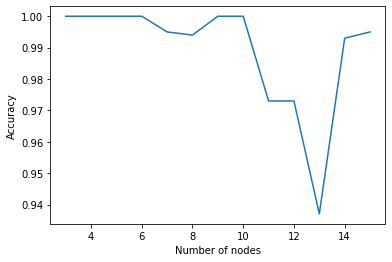

In [24]:
plt.plot(ns, scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of nodes')

In [25]:
planar_graphs = nx.read_graph6(f'datasets/planar_conn.{7}.g6')[:100]
tester(grid_search, planar_graphs, [1] * len(planar_graphs), energies_masses, energies)[2]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(1000, 54) (100, 24)
(1000, 54) (100, 54)
(54,) (24,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/100 [00:00<?, ?it/s]

0.92

## Find the best parameters

Now we look for the values of times and pulses to get the best accuracy score. This is done by bayesian optimization.

Define the score function

In [26]:
def get_score(param):
    middle = len(param)//2
    states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)
    # skf = StratifiedKFold(5, shuffle=True, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets).cv_results_

    return -np.max(result['mean_test_accuracy'])
    


Run the bayesian optimization (can take up to 15 min)

In [27]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
    
opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=30,
    n_initial_points=20,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1,
    verbose=True)

Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.2789
Function value obtained: -0.9964
Current minimum: -0.9964
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.9451
Function value obtained: -0.9978
Current minimum: -0.9978
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.3439
Function value obtained: -0.9978
Current minimum: -0.9978
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.6755
Function value obtained: -0.9988
Current minimum: -0.9988
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 20.7480
Function value obtained: -0.9971
Current minimum: -0.9988
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 20.7117
Function value obtained: -0.9972
Current minimum: -0.9988
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 19.7539
Function value obtained: -0.9975
Current minimum: -0.9988
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 21.0906
Function value obtained: -0.9970
Current minimum: -0.9988
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 19.9049
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 20.0971
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 20.6893
Function value obtained: -0.9975
Current minimum: -0.9988
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 20.1527
Function value obtained: -0.9982
Current minimum: -0.9988
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 20.7138
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 20.1224
Function value obtained: -0.9979
Current minimum: -0.9988
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 20.0562
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 20.6594
Function value obtained: -0.9982
Current minimum: -0.9988
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 20.1860
Function value obtained: -0.9988
Current minimum: -0.9988
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 20.6293
Function value obtained: -0.9984
Current minimum: -0.9988
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 19.8858
Function value obtained: -0.9974
Current minimum: -0.9988
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 20.3402
Function value obtained: -0.9958
Current minimum: -0.9988
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 20.0479
Function value obtained: -0.9986
Current minimum: -0.9988
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 20.7084
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 19.5230
Function value obtained: -0.9964
Current minimum: -0.9988
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 20.3558
Function value obtained: -0.9988
Current minimum: -0.9988
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 20.3818
Function value obtained: -0.9976
Current minimum: -0.9988
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 20.7911
Function value obtained: -0.9990
Current minimum: -0.9990
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 21.1099
Function value obtained: -0.9964
Current minimum: -0.9990
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 22.2002
Function value obtained: -0.9972
Current minimum: -0.9990
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 21.5449
Function value obtained: -0.9988
Current minimum: -0.9990
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 24.6780
Function value obtained: -0.9984
Current minimum: -0.9990


In [34]:
i_best = np.argmin(opt_result.func_vals)
print('Best accuracy: ', np.abs(opt_result.func_vals[i_best]))
print('Best parameters: ', opt_result.x_iters[i_best])

Best accuracy:  0.9989999999999999
Best parameters:  [1.3120541742020804, 1.1183939472347362, 0.6069423321714197, 0.774875787317455]


# Scalability test

In [32]:
# > opt_result.x_iters[i_best]
# [1.3120541742020804, 1.1183939472347362, 0.6069423321714197, 0.774875787317455]
times = opt_result.x_iters[i_best][:2]
pulses = opt_result.x_iters[i_best][2:]


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average

	# 2. Train model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.900% ± 0.300% for C=1000.0


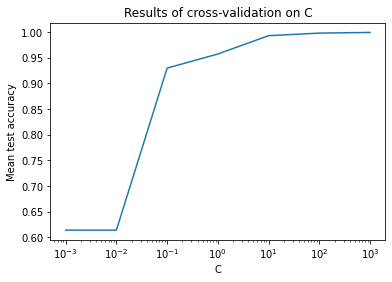

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[386   0]
 [  0 614]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       386
      Planar       1.00      1.00      1.00       614

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	# 4. Investigate generalisation capabilities


	#   a. 10 graphs of 18 nodes



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

[[8 1]
 [0 1]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.89      0.94         9
      Planar       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.94      0.80        10
weighted avg       0.95      0.90      0.91        10


	### Score: 90.00% (precision for planar: 0.500 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[218   0]
 [  0 782]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       218
      Planar       1.00      1.00      1.00       782

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       319
      Planar       1.00      1.00      1.00       681

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[489   0]
 [  5 506]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       489
      Planar       1.00      0.99      1.00       511

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


	### Score: 99.50% (precision for planar: 1.000 & non-planar: 0.990)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[445   0]
 [  0 555]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       445
      Planar       1.00      1.00      1.00       555

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[454   0]
 [  0 546]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       454
      Planar       1.00      1.00      1.00       546

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[537   0]
 [  0 463]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       537
      Planar       1.00      1.00      1.00       463

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[538  17]
 [ 32 413]]
              precision    recall  f1-score   support

  Non-planar       0.94      0.97      0.96       555
      Planar       0.96      0.93      0.94       445

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 95.10% (precision for planar: 0.960 & non-planar: 0.944)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[558   0]
 [ 38 404]]
              precision    recall  f1-score   support

  Non-planar       0.94      1.00      0.97       558
      Planar       1.00      0.91      0.96       442

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.20% (precision for planar: 1.000 & non-planar: 0.936)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[590   0]
 [ 28 382]]
              precision    recall  f1-score   support

  Non-planar       0.95      1.00      0.98       590
      Planar       1.00      0.93      0.96       410

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.20% (precision for planar: 1.000 & non-planar: 0.955)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[632   0]
 [ 55 313]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       632
      Planar       1.00      0.85      0.92       368

    accuracy                           0.94      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 94.50% (precision for planar: 1.000 & non-planar: 0.920)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[601   0]
 [ 88 311]]
              precision    recall  f1-score   support

  Non-planar       0.87      1.00      0.93       601
      Planar       1.00      0.78      0.88       399

    accuracy                           0.91      1000
   macro avg       0.94      0.89      0.90      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.20% (precision for planar: 1.000 & non-planar: 0.872)


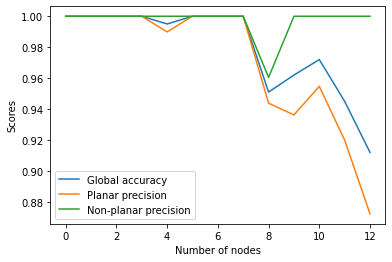

[(1.0, 1, 1),
 (1.0, 1, 1),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.995, 0.9898785425101214, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.951, 0.9438596491228071, 0.9604651162790697),
 (0.962, 0.9362416107382551, 1.0),
 (0.972, 0.9546925566343042, 1.0),
 (0.945, 0.9199417758369723, 1.0),
 (0.912, 0.872278664731495, 1.0)]

In [33]:
from qplanarity import test_suite

# times = [2.1, 1.6]
# pulses = [0.2, 0.1]
train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'

test_suite(times, pulses, train_ns, train_nbs, generator, seed=21)

In [48]:
times_taken = [0, 0, 0, 4, 6, 7, 8, 10, 12, 15, 22, 36, 63, 115, 223, 506]

In [63]:
def time_required(n_max):
    assert n_max >= 11, 'Useless for small number of nodes'
    low = 10 * 5 # 3 to 7
    med = 30 * 4 # 8 to 11
    high = 32 * 2**(n_max - 11 + 1) # + 1 as it is the sum of all the powers of 2 below
    tot = low + med + high
    print(f"{tot}s = {tot / 60:.2f}m = {tot/3600:.2f}h")
    return tot

In [66]:
time_required(len(times_taken) - 1), sum(times_taken)

1194s = 19.90m = 0.33h


(1194, 1027)

In [69]:
time_required(18)

8362s = 139.37m = 2.32h


8362

# Scalability optimisation test

In [ ]:
def get_score(param):
    """ 
    Uses global graphs, targets and observables_memoizer
    """
    middle = len(param)//2
    states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
               'f1_score': make_scorer(f1_score, average='weighted')}

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)
    estimator = svm.SVC(kernel='precomputed', random_state=76)
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets).cv_results_
    return -np.max(result['mean_test_accuracy'])
    


In [75]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
verbose = True
metric = 'precision'

scores = []
ns = range(5, 16)
N = 1000
for n in ns:
    if verbose: print(f"\n\t### {n} NODES ###")
    # Generate data
    graphs, targets = generate_graphs([n], [N], generator='binomial')
    observables_memoizer = Memoizer(observable)
    # Find optimized parameters
    opt_result = gp_minimize(
        get_score,
        bounds,
        acq_func='LCB',
        n_calls=30,
        n_initial_points=20,
        acq_optimizer='sampling',
        n_points=5000,
        kappa=4,
        n_jobs=-1,
        verbose=True
    )
    i_best = np.argmin(opt_result.func_vals)
    score = np.abs(opt_result.func_vals[i_best])
    times = opt_result.x_iters[i_best][:2]
    pulses = opt_result.x_iters[i_best][2:]
    if verbose:
        print(f"Score {score:6.1%} obtained for times {times} and pulses {pulses}")
    
    # Get trained model with found parameters
    model, energies_masses, energies = get_trained_model(times, pulses, graphs, targets, verbose=True)
    
    # Use model to predict on test data
    test_graphs, test_targets = generate_graphs([n], [N], generator='binomial')
    y_pred, y_true, score = predict(model, times, pulses, test_graphs, test_targets, energies_masses, energies, verbose=verbose)
    
    score_p, score_np = analyse_pred(y_pred, y_true, score, metric=metric, verbose=verbose)
    scores.append((score, score_p[metric], score_np[metric]))

# Plot scores
pd.DataFrame(scores, columns=['Global accuracy', f'Planar {metric}', f'Non-planar {metric}']).plot()
plt.ylabel('Scores')
plt.xlabel('Number of nodes')
plt.title('Score of optimised model')
plt.legend()
plt.show()


	### 8 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.7023
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.5129
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


KeyboardInterrupt: 

In [ ]:
# 1 iteration with N=1000 at n=5 takes 14s
# -> x30 = 7m
# 1 iteration with N=1000 at n=10 takes 29s
# -> x30 = 15m
# 1 iteration with N=1000 at n=15 takes more than 3min...
# -> x30 = 
# 1 iteration with N=1000 at n=8 takes 20s
# -> x30 = 10m
# 6h=360m / 30 
# Limit to 10: 7 + 9 + 9 + 10 + 13 + 15 = 63